In [1]:
import os.path
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import itertools
import seaborn as sns

from scipy import interpolate
from matplotlib import pyplot as plt

(1000, 2)


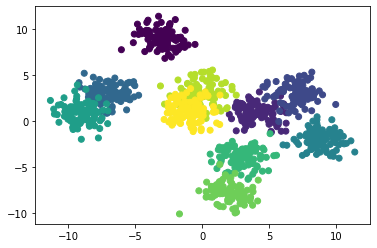

In [24]:
load=True
num_cells = 1000
num_dims_reduced = 2
num_branches = 2
K = 10 # cluster labels
if num_branches == 2:
    filename = 'fakedata-2branch.npy'
    start_node = 5
else:
    filename = 'fakedata-1branch.npy'
    start_node = 4

if load:
    data = np.load(filename, allow_pickle=True).item()
    cluster_labels = data['cluster_labels']
    data = data['data'].numpy()
else:
    cluster_labels = np.zeros([num_cells], dtype=int)
    data = list()
    for k in range(K):
        cells = num_cells // K
        offset = torch.randint(20, torch.Size([2])) - 10
        print(offset.shape)

        data.append(offset + torch.randn(torch.Size([num_cells//K, num_dims_reduced])))
        cluster_labels[k*cells:(k+1)*cells] = k
    data = torch.cat(data)
    np.save(filename, dict(data=data, cluster_labels=cluster_labels))
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)

cluster_labels_onehot = np.zeros((cluster_labels.shape[0], cluster_labels.max()+1))
cluster_labels_onehot[np.arange(cluster_labels.shape[0]), cluster_labels] = 1

print(data.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

Lineages: [Lineage[5, 3, 9, 8, 0], Lineage[5, 3, 9, 8, 1, 2, 4], Lineage[5, 3, 9, 8, 1, 6, 7]]
Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x7feef5a87710>, <pcurve.PrincipalCurve object at 0x7feef2a89fd0>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x7feef297f190>, <pcurve.PrincipalCurve object at 0x7feef4e400d0>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x7feef297f190>, <pcurve.PrincipalCurve object at 0x7feef4e400d0>]
avg interp [ 0.          1.54405201  2.27544738  3.12614744  3.99022432  4.86149201
  5.33611234  6.3647015  10.33086702 11.14537231 11.14537231 11.14537231
 11.14537231 11.14537231 11.14537231 11.14537231 11.16629856 11.25339545
 11.92375947 12.48850882 13.27627858 14.14114327 14.88716522 15.09752957
 15.09752957 15.10047314 15.10047314 15.10047314 15.10047314 15.10047314
 15.10047314 15.6733576  15.6733576  15.6733576 ] [[ 0.65798274  4.17764793]
 

 10%|█         | 1/10 [00:01<00:16,  1.87s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x7feef5327090>, <pcurve.PrincipalCurve object at 0x7feef2db2150>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x7feef4e05b10>, <pcurve.PrincipalCurve object at 0x7feef53952d0>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x7feef4e05b10>, <pcurve.PrincipalCurve object at 0x7feef53952d0>]
avg interp [ 0.          1.54405276  2.27544695  3.12614142  3.99022429  4.8431425
  5.33275823  6.33065262 10.30296227 11.12885793 11.14867583 11.14867583
 11.14867583 11.14867583 11.14867583 11.14867583 11.14867583 11.24750966
 11.91900118 12.48315841 13.28077874 14.10897139 14.59986318 15.10062344
 15.10430309 15.10430309 15.10430309 15.10430309 15.10430309 15.10430309
 15.10430309 15.6779646  15.6779646  15.6779646 ] [[ 0.67703371  4.17079963]
 [ 0.67703371  4.17079963]
 [ 0.67703371  4.17079963]
 [ 0.67703371  4.17079963]
 [ 1.18302778  4

 20%|██        | 2/10 [00:03<00:12,  1.54s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x7feef5a87590>, <pcurve.PrincipalCurve object at 0x7feef52a9f90>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x7feef4da0b90>, <pcurve.PrincipalCurve object at 0x7feef52a98d0>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x7feef4da0b90>, <pcurve.PrincipalCurve object at 0x7feef52a98d0>]
avg interp [ 0.          1.54405406  2.27544743  3.12614058  3.99022509  4.84894698
  5.33029995  6.30211696 10.28492924 11.14212876 11.14212876 11.14212876
 11.14212876 11.14212876 11.14212876 11.14212876 11.14212876 11.24466517
 11.91639568 12.48055226 13.27624161 13.99656628 14.54651696 15.10869241
 15.11222648 15.11222648 15.11222648 15.11222648 15.11222648 15.11222648
 15.11222648 15.68678195 15.68678195 15.68678195] [[ 0.69652808  4.16039278]
 [ 0.69652808  4.16039278]
 [ 0.69652808  4.16039278]
 [ 0.69652808  4.16039278]
 [ 1.1903873   

 30%|███       | 3/10 [00:04<00:09,  1.37s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x7feef5a87710>, <pcurve.PrincipalCurve object at 0x7feef2db2150>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x7feef5b3e1d0>, <pcurve.PrincipalCurve object at 0x7feef3bd92d0>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x7feef5b3e1d0>, <pcurve.PrincipalCurve object at 0x7feef3bd92d0>]
avg interp [ 0.          1.54405485  2.27544827  3.12614084  3.99022641  4.83551423
  5.3284698   6.30028145 10.28309593 11.13949145 11.13949145 11.13949145
 11.13949145 11.13949145 11.13949145 11.13949145 11.13949145 11.38403023
 11.96870852 12.50935794 13.27698626 14.05076112 14.52849182 15.11577137
 15.11577137 15.11577137 15.11577137 15.11577137 15.11577137 15.11577137
 15.11577137 15.69343822 15.69343822 15.69343822] [[ 0.71740501  4.14164285]
 [ 0.71740501  4.14164285]
 [ 0.71740501  4.14164285]
 [ 0.71740501  4.14164285]
 [ 1.21000512  

 40%|████      | 4/10 [00:05<00:08,  1.43s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x7feef5b3e1d0>, <pcurve.PrincipalCurve object at 0x7feef4da0f50>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x7feef5702490>, <pcurve.PrincipalCurve object at 0x7feef53952d0>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x7feef5702490>, <pcurve.PrincipalCurve object at 0x7feef53952d0>]
avg interp [ 0.          1.5440557   2.27544465  3.12613543  3.99022371  4.84634827
  5.3271902   6.27291341 10.08543806 11.12149455 11.1420488  11.1420488
 11.1420488  11.1420488  11.1420488  11.1420488  11.1420488  11.39286473
 12.00354335 12.64176258 13.2824298  14.07454604 14.50958166 15.11827641
 15.11827641 15.11827641 15.11827641 15.11827641 15.11827641 15.11827641
 15.11827641 15.6990827  15.6990827  15.6990827 ] [[ 0.73823047  4.11990105]
 [ 0.73823047  4.11990105]
 [ 0.73823047  4.11990105]
 [-5.98981022  2.60852837]
 [ 1.23214663  4

 50%|█████     | 5/10 [00:07<00:06,  1.39s/it]

nan: False False False False
avg [-10.48563453  -9.3719973   -8.84448594  -8.23092041  -7.60771616
  -6.99080031  -6.52210141  -5.73166172  -2.20602904  -1.20606914
  -0.94855239  -0.92412416  -0.45293698  -0.07508943  -0.07508943
  -0.07508943  -0.07508943   1.16443042   2.92252482   3.71001115
   4.03232843   4.03232843   4.03232843   4.45692759   5.21115676
   5.31647518   5.31647518   5.43723384   5.63172043   5.67774245
   5.71617437   5.71617437   5.71617437   5.71617437]
avg [-0.45958251  0.6099593   1.11658361  1.70585506  2.30438312  2.88471626
  2.76736176  2.53149786  1.47946357  1.18108008  1.1264307   1.16576884
  2.25996816  3.07623102  3.07623102  3.07623102  3.07623102  2.71239788
  1.63140647  1.18155488  0.97884983  0.97884983  0.97884983  0.6841002
 -0.64969894 -1.60479929 -1.60479929 -2.96980922 -5.71776175 -6.48664797
 -7.13591141 -7.13591141 -7.13591141 -7.13591141]
Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve objec

 60%|██████    | 6/10 [00:08<00:05,  1.37s/it]

avg interp [ 0.          1.54405557  2.27544807  3.12613916  3.99022578  4.84764836
  5.32283977  6.14771797  9.82696573 10.87040407 11.17696559 12.31234717
 13.25553531 13.27938555 13.27938555 13.27938555 14.50416647 16.69820629
 17.43167609 18.03519359 18.48555387 19.09789756 19.27402687 19.58353234
 21.0264367  21.78937378 22.22409316 22.63960092 23.2050945  23.7411216
 25.18931231 26.50881829 26.50881829 26.50881829] [[-0.07435416  3.0770446 ]
 [-0.07435416  3.0770446 ]
 [-0.07435416  3.0770446 ]
 [-5.98981031  2.6085284 ]
 [ 3.45726895  1.33051916]
 [ 3.39103639  1.36840417]
 [ 5.11411163  0.1953857 ]
 [ 5.11411163  0.1953857 ]
 [ 4.54540272  0.62084003]
 [ 5.11411163  0.1953857 ]
 [-7.05046228  2.83907619]
 [-7.61635632  2.29608507]
 [-5.94824302  2.59612492]
 [-6.98142936  2.88772516]
 [ 5.20118419 -0.39926842]
 [ 5.40970058 -2.26730843]
 [ 5.42900385 -2.48024785]
 [-9.13163864  0.84080077]
 [-7.59086247  2.32056945]
 [-8.6374874   1.31538595]
 [ 5.65065531 -5.44312778]
 [ 5.456

 70%|███████   | 7/10 [00:10<00:04,  1.48s/it]

Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x7feef3866150>, <pcurve.PrincipalCurve object at 0x7feef38317d0>]
avg interp [ 0.          1.54405559  2.27544798  3.12613885  3.99022572  4.83865633
  5.32199878  6.14687542  9.82612323 10.86941929 11.17477281 12.30960187
 13.2672485  13.2672485  13.2672485  13.29113817 14.48157304 16.70112547
 17.43508133 18.03777285 18.47690035 19.04739693 19.30173726 19.53849777
 21.05208817 21.78967258 22.22995381 22.64819268 23.21470888 23.7471474
 25.2035263  26.39872789 26.39872789 26.39872789] [[-0.08264786  3.07227094]
 [-0.08264786  3.07227094]
 [-0.08264786  3.07227094]
 [-5.98981056  2.60852847]
 [ 3.45891743  1.33481045]
 [ 3.39270513  1.37294278]
 [ 5.13073319  0.17756016]
 [ 5.13073319  0.17756016]
 [ 4.5609355   0.61219428]
 [ 5.13073319  0.17756016]
 [-7.05019029  2.83913164]
 [-7.61635625  2.29608514]
 [-5.94824275  2.59612484]
 [-6.96395681  2.88870873]
 [ 5.22424971 -0.42002656]
 [ 5.44159139 -2.27376288]
 [ 5.4617

 80%|████████  | 8/10 [00:12<00:03,  1.65s/it]

avg interp [ 0.          1.54405553  2.27544802  3.1261382   3.99022566  4.830206
  5.32114046  6.14601609  9.82526388 10.8684399  11.17332999 12.25307069
 13.25154936 13.27591173 13.27591173 13.27591173 14.41558554 16.68859804
 17.42919291 18.04686073 18.46440554 19.01242678 19.32870072 19.36910852
 21.06628543 21.78700668 22.22827884 22.63251058 23.22376748 23.7539429
 25.21811938 26.28929629 26.28929629 26.28929629] [[-0.0697347   3.0756489 ]
 [-0.0697347   3.0756489 ]
 [-0.0697347   3.0756489 ]
 [-5.98981047  2.60852844]
 [ 3.46051036  1.33899119]
 [ 3.39433834  1.37735688]
 [ 5.14687759  0.1597377 ]
 [ 5.14687759  0.1597377 ]
 [ 4.58154851  0.59899895]
 [ 5.14687759  0.1597377 ]
 [-7.04698036  2.84203346]
 [-7.61635606  2.29608532]
 [-5.94824216  2.59612466]
 [-6.96989098  2.88744967]
 [ 5.24749833 -0.44216821]
 [ 5.47332554 -2.27914252]
 [ 5.49419292 -2.4942708 ]
 [-9.13163866  0.84080076]
 [-7.59086236  2.32056956]
 [-8.63748749  1.31538589]
 [ 5.72128214 -5.43762009]
 [ 5.51937

 90%|█████████ | 9/10 [00:14<00:01,  1.75s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x7feef5460f10>, <pcurve.PrincipalCurve object at 0x7feef4aa37d0>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x7feef4f3bb90>, <pcurve.PrincipalCurve object at 0x7feef57383d0>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x7feef4f3bb90>, <pcurve.PrincipalCurve object at 0x7feef57383d0>]
avg interp [ 0.          1.54405559  2.2754469   3.12613388  3.99022604  4.82767058
  5.32003361  6.16605668  9.90237442 10.93498016 11.12824648 11.12824648
 11.12824648 11.12824648 11.12824648 11.12824648 11.14924608 11.44849094
 12.06463451 12.92771988 13.58027139 14.29431538 14.50227487 15.14114444
 15.14114444 15.14114444 15.14114444 15.14114444 15.14114444 15.14114444
 15.14114444 15.74910613 15.74910613 15.74910613] [[ 0.83982658  3.97837284]
 [ 0.83982658  3.97837284]
 [ 0.83982658  3.97837284]
 [-5.98981211  2.60852893]
 [ 1.08926231  

100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


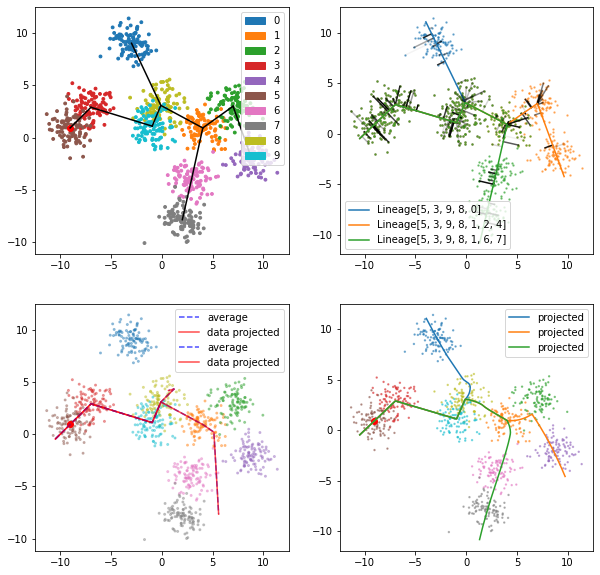

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

from slingshot import Slingshot

slingshot = Slingshot(data, cluster_labels_onehot, start_node=start_node, debug_level='verbose')

slingshot.fit(num_epochs=10, debug_axes=axes)

In [ ]:
tttttt


In [ ]:
def scipy_interpolate():
    x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
    y = np.sin(x)

    tck = interpolate.splrep(x, y, s=0.5)
    xnew = np.arange(0, 2*np.pi, np.pi/50)

    ynew = interpolate.splev(xnew, tck, der=0)

    plt.plot(xnew, ynew)
    plt.plot(xnew, np.sin(xnew))


